# Referencias

**FeatureTools**  

> https://featuretools.alteryx.com/en/stable/  

**Medium** -> Usar luego un arbol para clasificar

> https://ranasinghiitkgp.medium.com/feature-engineering-using-featuretools-with-code-10f8c83e5f68

**Demo**

> https://chatgpt.com/share/8ec15bc1-781c-475d-b356-64576f3ad47f

**PCAs visualizaciones**  

URL original 
> https://towardsdatascience.com/5-pca-visualizations-you-must-try-on-your-next-data-science-project-148ec3d31e4d

Freedium
> https://freedium.cfd/https://towardsdatascience.com/5-pca-visualizations-you-must-try-on-your-next-data-science-project-148ec3d31e4d
  

>Hola Nicole,En primer lugar, ¡bienvenida a la empresa!Hablando con Michelle, hemos pensado que sería ideal que pudiéramos identificar grupos de productos que se comportan de manera similar. Michelle estaba diciendo que con tu magia es fácil identificar grupos de productos similares, y tales grupos serán súper útiles para evaluar el rendimiento de nuestras diferentes campañas. ¿Cuántos grupos crees que deberíamos considerar? 5? 10? 20? Además, ¿crees que podríamos encontrar un enfoque ”similar" para identificar cómo de similares son las tiendas entre sí? ¿La agrupación de tiendas también tendría sentido aquí? ¿Podrías hacer eso también?¡Me alegra que finalmente podamos contar con alguien con tus habilidades dentro del equipo! Saludos -- <cite>- Joelle</cite>

___

# 1. INIT

In [47]:
import pandas as pd
import numpy as np

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns',100)
pd.set_option('display.width',100)
pd.set_option('display.max_colwidth',100)

In [48]:
# Conectar a db
import os
import pymongo
from dotenv import load_dotenv

# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Obtener la URI de MongoDB desde las variables de entorno
URI = os.getenv('LOCAL.URI')

# print(f'URI: {URI}')
# Verificar si la URI se ha cargado correctamente
if not URI:
    raise ValueError("No se ha encontrado la URI de MongoDB en las variables de entorno")

try:
    # Conéctate a tu servidor MongoDB
    client = pymongo.MongoClient(URI, serverSelectionTimeoutMS=5000)  
    
    # Prueba la conexión
    client.server_info()  # Esto lanzará una excepción si no puede conectarse
    print("Conexión exitosa")
    
    # Selecciona la base de datos y las colecciones
    db = client['ds_market']

except Exception as e:
    print(f"Error de conexión: {e}")

Conexión exitosa


In [49]:
def get_collection(collect_name):
    # Leemos coleccion que queremos y guardamos en dataframe
    collection = db[collect_name]

    # Contar el número de documentos en la colección
    document_count = collection.count_documents({})

    print(f"El número de documentos en la {collect_name} es: {document_count}")

    # Leer la colección
    docs = collection.find()

    # Convertir los docs a una lista
    list_docs = list(docs)

    # Convertir la lista de docs a un DataFrame de pandas
    _df = pd.DataFrame(list_docs)

    return _df

In [50]:
db_collections = [
    'calendar',
    'items',
    'prices',
    'tiendas',
    'departments',
    'sales_main',
    'weekly_sales',
    'year_sales',
    'day_sales'
    ]

In [51]:
df_cal = get_collection('calendar').drop(columns='_id')
df_cal = df_cal.fillna('None') # event tiene NaN

# Añadimos columnas week y month a calendar para hacer cruces de datos mas faciles
'''
# DONE
calendar_collection = db['calendar']

display(df_cal.head())

df_cal['date'] = pd.to_datetime(df_cal['date'])

# Añadimos numero de mes
df_cal['month'] = df_cal['date'].dt.month

# Añadimos semana
df_cal['week'] = df_cal['date'].dt.isocalendar().week

# Rellenamos NaN con str 'None'
df_cal['event'] = df_cal['event'].fillna('None')

# Itera sobre las filas del DataFrame y actualiza los documentos en la colección 'calendar'
for index, row in df_cal.iterrows():
    # Define los campos a actualizar
    update_fields = {
        'week': row['week'],
        'month': row['month']
    }
    
    # Actualiza el documento con los nuevos campos
    calendar_collection.update_one({'_id': row['_id']}, {'$set': update_fields})

# Imprime un mensaje de finalización
print('Actualización completada')
'''

El número de documentos en la calendar es: 1913


"\n# DONE\ncalendar_collection = db['calendar']\n\ndisplay(df_cal.head())\n\ndf_cal['date'] = pd.to_datetime(df_cal['date'])\n\n# Añadimos numero de mes\ndf_cal['month'] = df_cal['date'].dt.month\n\n# Añadimos semana\ndf_cal['week'] = df_cal['date'].dt.isocalendar().week\n\n# Rellenamos NaN con str 'None'\ndf_cal['event'] = df_cal['event'].fillna('None')\n\n# Itera sobre las filas del DataFrame y actualiza los documentos en la colección 'calendar'\nfor index, row in df_cal.iterrows():\n    # Define los campos a actualizar\n    update_fields = {\n        'week': row['week'],\n        'month': row['month']\n    }\n    \n    # Actualiza el documento con los nuevos campos\n    calendar_collection.update_one({'_id': row['_id']}, {'$set': update_fields})\n\n# Imprime un mensaje de finalización\nprint('Actualización completada')\n"

In [52]:
df_shops = get_collection('tiendas').drop(columns='_id')
df_items = get_collection('items').drop(columns='_id')

df_ws = get_collection('weekly_sales').drop(columns='_id')

# Añadimos eventos para no perder esa información
# Crear un diccionario desde df_cal
event_dict = df_cal.set_index('week')['event'].to_dict()

# Añadir la columna 'event' a df_ws usando el método 'map'
df_ws['event'] = df_ws['week'].map(event_dict)

El número de documentos en la tiendas es: 10
El número de documentos en la items es: 3049
El número de documentos en la weekly_sales es: 5016091


# 2. IDEAS

> https://retalon.com/blog/product-clustering

> https://chatgpt.com/c/3aba0867-3db3-4123-ba86-31a4d40700fc

- Según performance general
- Según performance en eventos
- Según rangos de precios

# 3. Clustering Productos

## 1. Librerias

In [67]:
import featuretools as ft
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

## 2. ITERACIONES

In [54]:
display(df_items.head(3), df_shops.head(3), df_ws.head(3))

,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca


,item,store_code,year,week,units,sell_price,raw_earn,event
0,SUPERMARKET_2_335,NYC_4,2011,14,3,4.54,13.61,None
1,SUPERMARKET_2_359,NYC_3,2011,26,28,2.36,66.19,None
2,SUPERMARKET_2_359,NYC_3,2011,25,18,2.36,42.55,None


In [55]:
# Crear el EntitySet
es = ft.EntitySet(id="sales_data")

# Añadir las tablas como dataframes
es = es.add_dataframe(dataframe_name="items", dataframe=df_items, index="item")
es = es.add_dataframe(dataframe_name="shops", dataframe=df_shops, index="store_code")
es = es.add_dataframe(dataframe_name="sales", dataframe=df_ws, 
                      index="id", make_index=True, time_index="week")

# Definir las relaciones entre tablas
es = es.add_relationship("shops", "store_code", "sales", "store_code")
es = es.add_relationship("items", "item", "sales", "item")


C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, fall

In [56]:
# Obtener descripciones de las características
def get_features_descriptions(features):
    for desc in features:
        feat_desc = ft.describe_feature(desc)
        print(f'{desc}: {feat_desc}')

### 2.1 Ventas / Performance

#### Creacion caracteristicas

##### REVISAR LIBRERIA FEATTOOLS
**Feature encode** (codifica categorical)

> https://featuretools.alteryx.com/en/stable/api_reference.html#feature-encoding

**Feature selection**

> https://featuretools.alteryx.com/en/stable/api_reference.html#feature-selection  
  
- *remove_low_information_features(feature_matrix)*  
Select features that have at least 2 unique values and that are not all null

- *remove_highly_correlated_features(feature_matrix)*  
Removes columns in feature matrix that are highly correlated with another column.

- *remove_highly_null_features(feature_matrix)*  
Removes columns from a feature matrix that have higher than a set threshold of null values.

- *remove_single_value_features(feature_matrix)*  
Removes columns in feature matrix where all the values are the same.

In [57]:
# Crear características agregadas relevantes para los productos
# Usamos las funciones de agregación estándar de featuretools: SUM, MEAN, STD, COUNT
feature_matrix_sales, feature_defs_sales = ft.dfs(
    entityset=es,
    target_dataframe_name="items",
    agg_primitives=["sum", "mean", "std", "count"],  # Primitivas estándar de agregación
    trans_primitives=[],  # No necesitamos transformaciones adicionales aquí
    max_depth=2
)

C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function mean at 0x000001F9B45751C0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ).agg(to_agg)
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function std at 0x000001F9B4575300> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  ).agg(to_agg)
C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Py

In [58]:
# Obtenemos descripciones de las caracteristicas
get_features_descriptions(feature_defs_sales)

<Feature: category>: The "category".
<Feature: department>: The "department".
<Feature: COUNT(sales)>: The number of all instances of "sales" for each "item" in "items".
<Feature: MEAN(sales.raw_earn)>: The average of the "raw_earn" of all instances of "sales" for each "item" in "items".
<Feature: MEAN(sales.sell_price)>: The average of the "sell_price" of all instances of "sales" for each "item" in "items".
<Feature: MEAN(sales.units)>: The average of the "units" of all instances of "sales" for each "item" in "items".
<Feature: MEAN(sales.week)>: The average of the "week" of all instances of "sales" for each "item" in "items".
<Feature: MEAN(sales.year)>: The average of the "year" of all instances of "sales" for each "item" in "items".
<Feature: STD(sales.raw_earn)>: The standard deviation of the "raw_earn" of all instances of "sales" for each "item" in "items".
<Feature: STD(sales.sell_price)>: The standard deviation of the "sell_price" of all instances of "sales" for each "item" in 

In [59]:
# Seleccionar características relevantes para el clustering de ventas/performance
selected_features = {
    'COUNT(sales)': 'num_sales',                   # Número de ventas
    'SUM(sales.units)': 'total_units_sold',        # Total de unidades vendidas
    'SUM(sales.raw_earn)': 'total_revenue',        # Ingresos totales
    'MEAN(sales.sell_price)': 'avg_sell_price',    # Precio promedio de venta
    'STD(sales.sell_price)': 'std_sell_price',     # Desviación estándar del precio de venta
    'STD(sales.units)': 'std_units_sold',          # Desviación estándar de unidades vendidas
    'MEAN(sales.units)': 'avg_units_per_week',     # Promedio de unidades vendidas
    'MEAN(sales.week)': 'avg_week',                # Promedio de la semana
    'STD(sales.week)': 'std_week',                 # Desviación estándar de la semana
    'MEAN(sales.year)': 'avg_year'                 # Promedio del año
}

# Filtrar la matriz de características para mantener solo las seleccionadas y renombrar columnas
fm_selected_sales = feature_matrix_sales[list(selected_features.keys())]
fm_selected_sales.rename(columns=selected_features, inplace=True)

# Mostrar las primeras filas de la matriz filtrada y renombrada
display(fm_selected_sales.head())

,num_sales,total_units_sold,total_revenue,avg_sell_price,std_sell_price,std_units_sold,avg_units_per_week,avg_week,std_week,avg_year
item,,,,,,,,,,
ACCESORIES_1_001,1185,4093.00,44559.73,11.01,0.19,2.24,3.45,27.13,15.69,2014.46
ACCESORIES_1_002,1899,5059.00,26639.47,5.28,0.09,2.21,2.66,27.79,15.15,2013.29
ACCESORIES_1_003,665,1435.00,5533.73,3.94,0.18,1.63,2.16,23.95,15.02,2014.91
ACCESORIES_1_004,2512,39175.00,234283.92,5.99,0.27,12.96,15.60,25.86,15.16,2013.22
ACCESORIES_1_005,2134,14621.00,55310.59,3.83,0.23,4.94,6.85,27.07,15.36,2013.46


#### Estandarizacion y normalizacion

In [60]:
scaled_df = preprocess_features(fm_selected_sales)

scaled_df.head()

Cat cols: 0
Num cols: 10


,num_sales,total_units_sold,total_revenue,avg_sell_price,std_sell_price,std_units_sold,avg_units_per_week,avg_week,std_week,avg_year
0,-0.50,-0.32,0.02,1.50,0.21,-0.35,-0.30,1.09,0.70,0.97
1,0.21,-0.26,-0.27,0.24,-0.23,-0.36,-0.40,1.74,-0.21,-0.18
2,-1.01,-0.47,-0.61,-0.05,0.19,-0.45,-0.46,-2.03,-0.44,1.41
3,0.82,1.73,3.10,0.40,0.58,1.43,1.23,-0.15,-0.19,-0.26
4,0.44,0.30,0.20,-0.08,0.40,0.10,0.13,1.03,0.15,-0.01


#### Clustering - KMeans

##### Elbow

Inertia 87754.4997286374 for 1
Inertia 54941.81294669566 for 2
Inertia 42726.39814523585 for 3
Inertia 38672.7195950664 for 4
Inertia 31782.891868179613 for 5
Inertia 29170.90438828723 for 6
Inertia 25656.45288557889 for 7
Inertia 23509.328741105528 for 8
Inertia 20929.05283933116 for 9
Inertia 19989.19907416297 for 10
Inertia 19430.792276164855 for 11
Inertia 18960.381747137715 for 12
Inertia 17976.40937941445 for 13
Inertia 17144.50707893366 for 14
Inertia 15939.040051824119 for 15
Inertia 15294.812737277978 for 16
Inertia 14646.536999878506 for 17
Inertia 14261.00262058272 for 18
Inertia 13699.758772167772 for 19


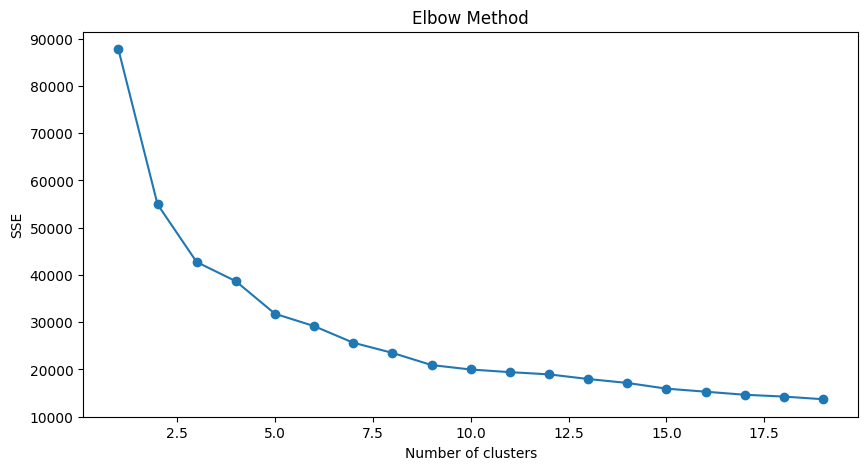

In [61]:
sse_values = plot_elbow_method(scaled_df, 20)  # 10 es un ejemplo de max_range

# display(sse_values)

##### Shilouette

Silhouette Score avg: 0.7423906035163487 for 2
Silhouette Score avg: 0.5716881459714889 for 3
Silhouette Score avg: 0.29992305137304487 for 4
Silhouette Score avg: 0.3099711659024318 for 5
Silhouette Score avg: 0.2076554990927187 for 6
Silhouette Score avg: 0.1674981750006627 for 7
Silhouette Score avg: 0.17405132499673015 for 8
Silhouette Score avg: 0.20169539928153246 for 9
Silhouette Score avg: 0.17228467869004985 for 10
Silhouette Score avg: 0.16947649359152855 for 11
Silhouette Score avg: 0.16919841716995604 for 12
Silhouette Score avg: 0.16663069444868037 for 13
Silhouette Score avg: 0.1699598938325989 for 14
Silhouette Score avg: 0.17312271724640232 for 15
Silhouette Score avg: 0.17520824270455984 for 16
Silhouette Score avg: 0.1762269755747485 for 17
Silhouette Score avg: 0.17451272983469104 for 18
Silhouette Score avg: 0.17989061441964405 for 19


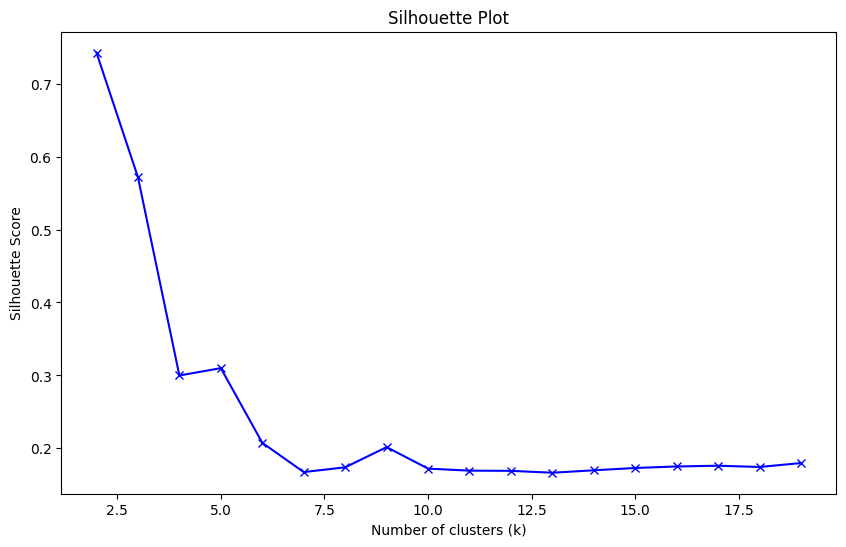

In [62]:
silhouette_scores = plot_silhouette_scores(scaled_df, 20)

##### Optimal K

                  num_sales  total_units_sold  total_revenue  avg_sell_price  std_sell_price  \
item                                                                                           
ACCESORIES_1_001       1185           4093.00       44559.73           11.01            0.19   
ACCESORIES_1_002       1899           5059.00       26639.47            5.28            0.09   
ACCESORIES_1_003        665           1435.00        5533.73            3.94            0.18   
ACCESORIES_1_004       2512          39175.00      234283.92            5.99            0.27   
ACCESORIES_1_005       2134          14621.00       55310.59            3.83            0.23   

                  std_units_sold  avg_units_per_week  avg_week  std_week  avg_year  Cluster  
item                                                                                         
ACCESORIES_1_001            2.24                3.45     27.13     15.69   2014.46        6  
ACCESORIES_1_002            2.21             

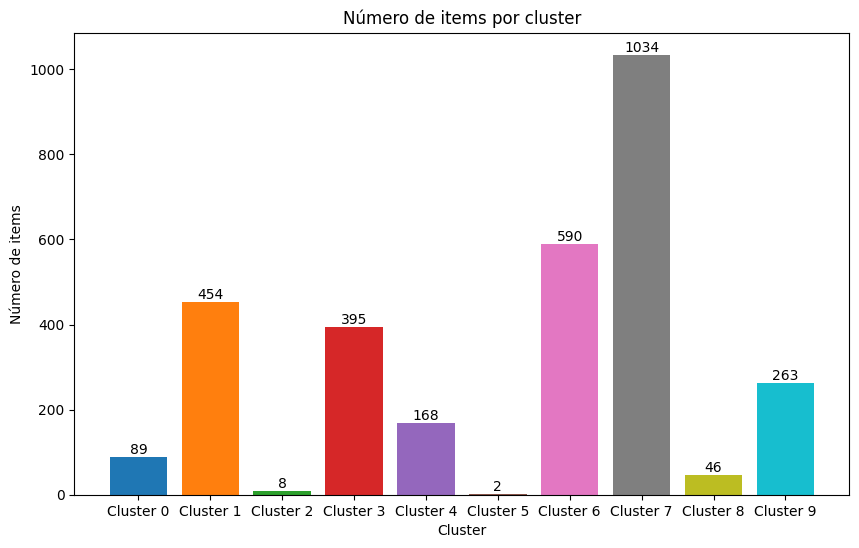

,num_sales,total_units_sold,total_revenue,avg_sell_price,std_sell_price,std_units_sold,avg_units_per_week,avg_week,std_week,avg_year,Cluster
item,,,,,,,,,,,
ACCESORIES_1_001,1185,4093.00,44559.73,11.01,0.19,2.24,3.45,27.13,15.69,2014.46,6
ACCESORIES_1_002,1899,5059.00,26639.47,5.28,0.09,2.21,2.66,27.79,15.15,2013.29,6
ACCESORIES_1_003,665,1435.00,5533.73,3.94,0.18,1.63,2.16,23.95,15.02,2014.91,7
ACCESORIES_1_004,2512,39175.00,234283.92,5.99,0.27,12.96,15.60,25.86,15.16,2013.22,1
ACCESORIES_1_005,2134,14621.00,55310.59,3.83,0.23,4.94,6.85,27.07,15.36,2013.46,7


In [63]:
optimal_k = 10 # Segun silueta

kmeans_model, feature_matrix_with_clusters = apply_kmeans_and_plot(optimal_k, scaled_df, fm_selected_sales)

feature_matrix_with_clusters.head(5)

##### Analisis

__PCAs__

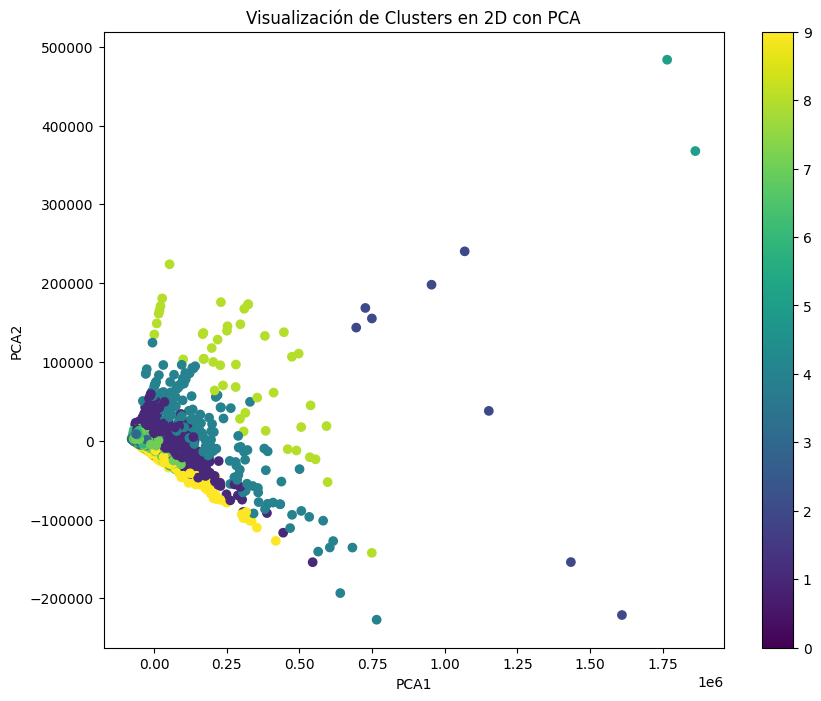

,PCA1,PCA2,Cluster
0,-34520.50,-7649.05,6
1,-51364.41,-1458.83,6
2,-72605.81,1276.35,7
3,157139.32,-29860.03,1
4,-21148.89,-742.95,7


In [64]:
pca_df = pca_visualization_2d(feature_matrix_with_clusters, cluster_col='Cluster')

display(pca_df.head())

Principal Component 1: 0.94
Principal Component 2: 0.06
Principal Component 3: 0.00
Principal Component 4: 0.00
Principal Component 5: 0.00
Principal Component 6: 0.00
Principal Component 7: 0.00
Principal Component 8: 0.00
Principal Component 9: 0.00
Principal Component 10: 0.00
Principal Component 11: 0.00


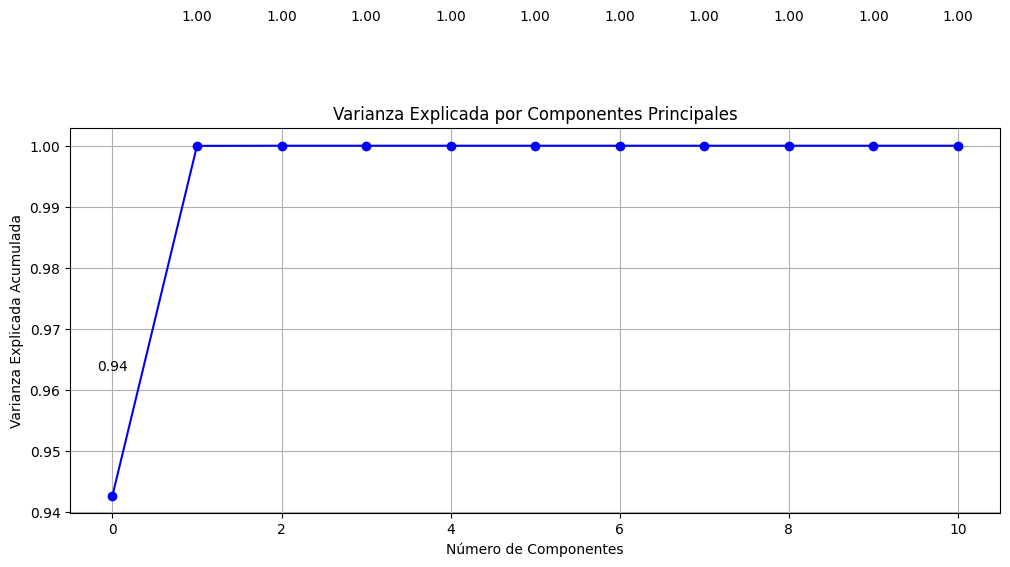

In [65]:
pca_variance_plot(feature_matrix_with_clusters)

__Descripcion con RandomForest__

Cat cols: 0
Num cols: 10


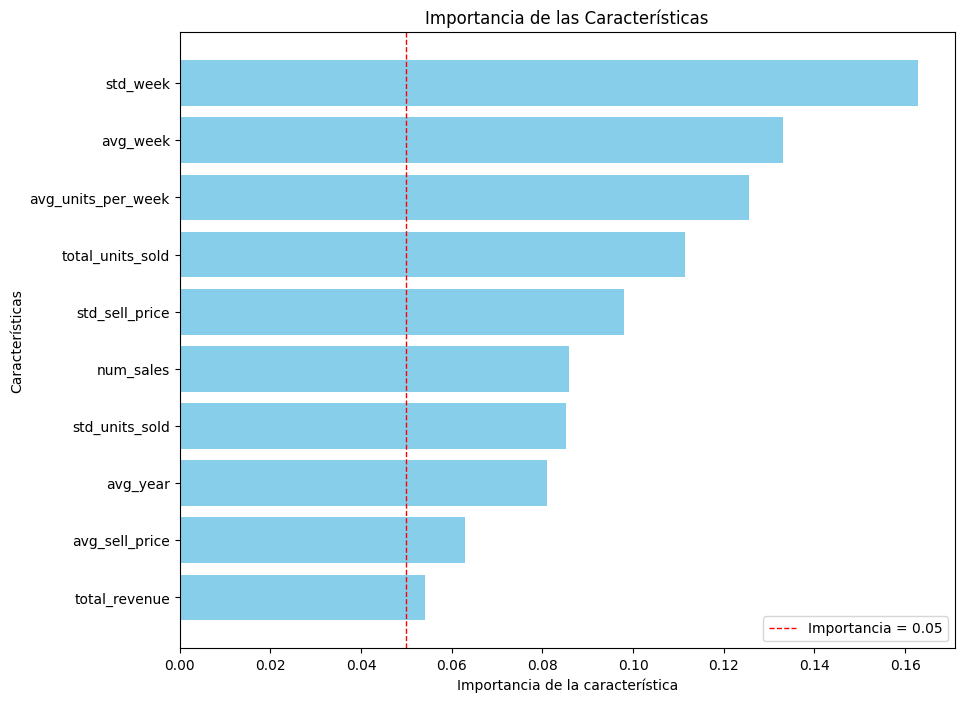

,Feature,Importance
0,std_week,0.16
1,avg_week,0.13
2,avg_units_per_week,0.13
3,total_units_sold,0.11
4,std_sell_price,0.10
5,num_sales,0.09
6,std_units_sold,0.09
7,avg_year,0.08
8,avg_sell_price,0.06
9,total_revenue,0.05


In [77]:
# Preprocesamos datos
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[['Cluster']].copy().reset_index(drop=True)
cols_to_scale.remove('Cluster') # Columna Objetivo
scaled_df = preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
scaled_df = pd.concat([scaled_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

cluster_col = 'Cluster'

# sales_importance_df = get_feature_importances(feature_matrix_with_clusters, clusters, imp_threshold=0.05)
sales_importance_df = get_feature_importances(scaled_df, clusters, imp_threshold=0.05)

display(sales_importance_df.head(10))

#### Reducir dimensionalidad

Características más importantes:


,Feature,Loading_PC1
1,total_units_sold,0.56
5,std_units_sold,0.54
6,avg_units_per_week,0.52
2,total_revenue,0.31
0,num_sales,0.04
8,std_week,0.01
7,avg_week,-0.01
9,avg_year,-0.02
4,std_sell_price,-0.03
3,avg_sell_price,-0.05


<Figure size 1500x500 with 0 Axes>

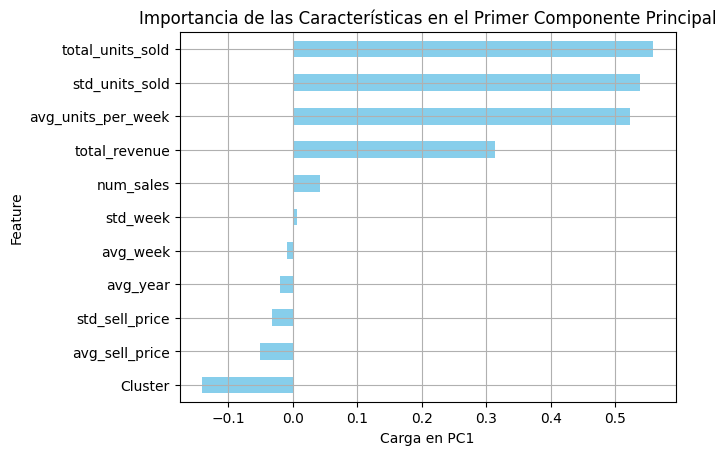

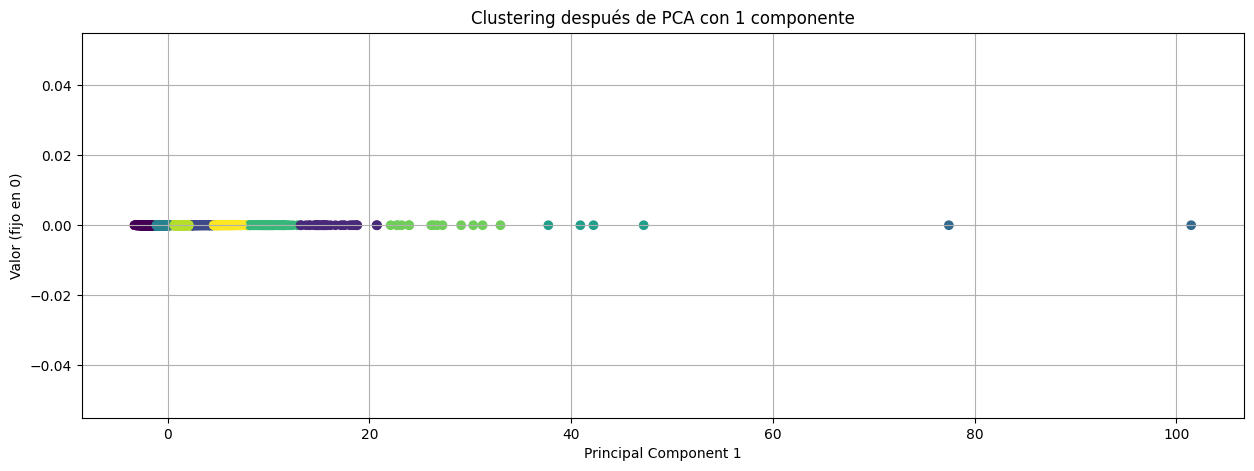

In [78]:
pca_df, importance_df = redux_dimensions_pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=1)
# display(pca_df.head())

#### Etiquetado y descripcion clusters

##### !!! **REFACTORIZAR**

,num_sales,total_units_sold,total_revenue,avg_sell_price,std_sell_price,std_units_sold,avg_units_per_week,avg_week,std_week,avg_year,Cluster,PC1
0,-0.50,-0.32,0.02,1.50,0.21,-0.35,-0.30,1.09,0.70,0.97,0,-2.02
1,0.21,-0.26,-0.27,0.24,-0.23,-0.36,-0.40,1.74,-0.21,-0.18,0,-2.01
2,-1.01,-0.47,-0.61,-0.05,0.19,-0.45,-0.46,-2.03,-0.44,1.41,0,-2.52
3,0.82,1.73,3.10,0.40,0.58,1.43,1.23,-0.15,-0.19,-0.26,2,2.69
4,0.44,0.30,0.20,-0.08,0.40,0.10,0.13,1.03,0.15,-0.01,4,-1.16


C:\Users\alexa\AppData\Local\Temp\ipykernel_12588\3578392704.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', len(cluster_counts))


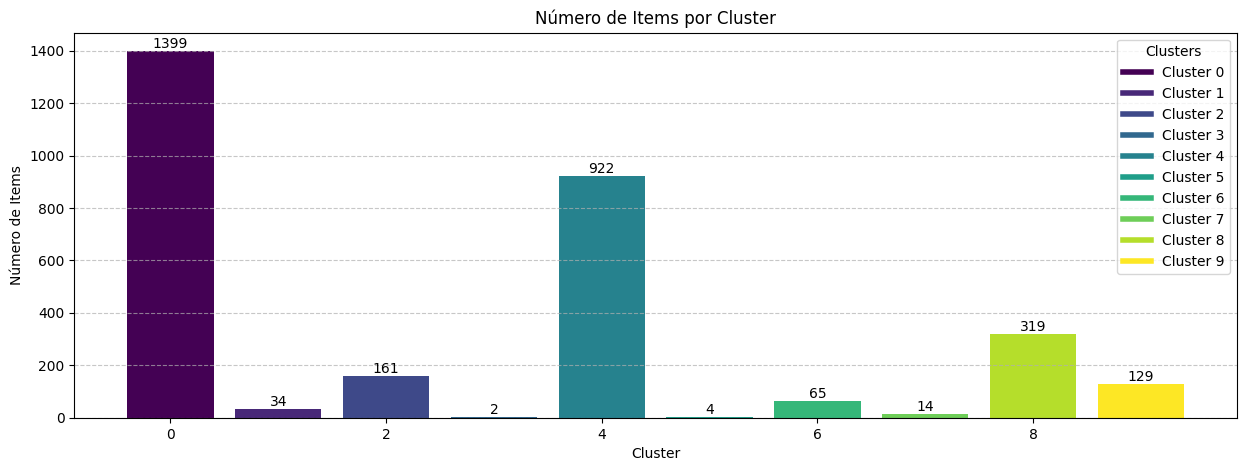

,0,2,4,9,8,6,1,7,3,5
total_units_sold,-0.27,2.08,0.24,3.61,1.06,5.99,9.88,16.22,55.68,24.83
std_units_sold,-0.32,2.15,0.26,3.68,1.12,6.56,10.53,15.62,47.28,21.06
avg_units_per_week,-0.31,2.12,0.27,3.56,1.11,5.83,9.83,14.61,49.15,22.35
total_revenue,-0.19,1.65,0.33,2.60,1.02,3.55,4.49,8.23,26.60,18.75
num_sales,-0.30,0.35,0.04,0.43,0.26,0.48,0.48,0.67,0.78,0.66


In [79]:
# Pendiente añadir información a items originales
# Ver grafico de barras de items por cluster
# Crear etiquetas explicativas de los clusters en funcion de su descripcion

def pca_and_cluster(df, n_clusters=3, n_components=2):
    
    # Ajustar PCA con el número de componentes especificado (1 o 2)
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(df)
    
    # Convertir el resultado a DataFrame
    pca_columns = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pca_results, columns=pca_columns)
    
    # Aplicar KMeans con el número de clusters especificado
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    pca_df['Cluster'] = kmeans.fit_predict(pca_df)
    
    # Obtener las cargas de los componentes principales
    loadings = pca.components_.T  # Transponer para alinear con las características
    feature_names = df.columns
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Loading_PC1': loadings[:, 0],
        'Loading_PC2': loadings[:, 1] if n_components > 1 else np.nan
    })
    
    # Ordenar por la importancia en el primer componente principal
    importance_df = importance_df.sort_values(by='Loading_PC1', ascending=False)
    
    # Añadir los resultados al DataFrame original
    df_with_pca = df.copy()
    df_with_pca[pca_columns] = pca_df[pca_columns]
    df_with_pca['Cluster'] = pca_df['Cluster']
    
    return df_with_pca, importance_df

def plot_items_per_cluster(df_with_pca):
    # Contar la cantidad de items en cada cluster
    cluster_counts = df_with_pca['Cluster'].value_counts().sort_index()
    
    # Definir una paleta de colores
    colormap = cm.get_cmap('viridis', len(cluster_counts))
    
    # Crear gráfico de barras
    plt.figure(figsize=(15, 5))
    bars = plt.bar(cluster_counts.index, cluster_counts, color=colormap(range(len(cluster_counts))))
    plt.xlabel('Cluster')
    plt.ylabel('Número de Items')
    plt.title('Número de Items por Cluster')
    
    # Añadir etiquetas a las barras
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')
    
    # Crear una leyenda para los colores
    plt.legend(handles=[plt.Line2D([0], [0], color=colormap(i), lw=4) for i in range(len(cluster_counts))],
               labels=[f'Cluster {i}' for i in cluster_counts.index],
               title='Clusters')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def create_cluster_descriptions(df_with_pca, importance_df):
    cluster_descriptions = {}
    
    for cluster in df_with_pca['Cluster'].unique():
        cluster_data = df_with_pca[df_with_pca['Cluster'] == cluster]
        
        # Calcular las medias de las características originales para cada cluster
        cluster_means = cluster_data.mean()
        
        # Seleccionar las características más importantes basadas en las importancias
        important_features = importance_df.head(5)['Feature']
        important_means = cluster_means[important_features]
        
        description = pd.Series(important_means, name=f'Cluster {cluster}')
        cluster_descriptions[cluster] = description
    
    # Convertir el diccionario en un DataFrame
    description_df = pd.DataFrame(cluster_descriptions)
    
    return description_df

# Ejecutar PCA y clustering
optimal_k = 10
n_components = 1
df_with_pca, importance_df = pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
plot_items_per_cluster(df_with_pca)

# Crear y mostrar descripciones de los clusters
cluster_descriptions = create_cluster_descriptions(df_with_pca, importance_df)
description_df = create_cluster_descriptions(df_with_pca, importance_df)
display(description_df)


__Etiquetado clusters__

1\. **Cluster 0: "Bajo rendimiento en ventas y ingresos"**

   - **Justificación**: Los valores en este cluster son negativos en todas las métricas, indicando bajo rendimiento en unidades vendidas, desviación estándar de ventas, promedio de unidades por semana, ingresos y número de ventas. Esto sugiere que estos productos tienen un rendimiento bajo en términos generales.

2\. **Cluster 1: "Alto rendimiento en ventas con alta consistencia"**

   - **Justificación**: Este cluster muestra valores positivos altos en ventas y frecuencia de ventas, pero con una desviación estándar relativamente baja. Esto indica que estos productos generan muchas ventas y tienen un rendimiento alto en general, pero con una consistencia en sus patrones de venta.

3\. **Cluster 2: "Rendimiento moderado en ventas e ingresos"**

   - **Justificación**: Los valores en este cluster son moderadamente positivos en la mayoría de las métricas. Esto indica un rendimiento aceptable, pero no excepcional, en términos de ventas, ingresos y frecuencia de ventas.

4\. **Cluster 3: "Ventas e ingresos altos con moderada frecuencia de ventas"**

   - **Justificación**: Este cluster muestra valores altos en ventas y en desviación estándar, lo que indica que estos productos tienen un rendimiento muy alto en ventas e ingresos con una frecuencia de ventas moderada. Hay alta variabilidad en los datos de ventas.

5\. **Cluster 4: "Ventas e ingresos muy altos con alta frecuencia de ventas"**

   - **Justificación**: Los valores muy altos en ventas, ingresos y frecuencia de ventas, junto con desviaciones estándar relativamente altas, sugieren que estos productos generan muchas ventas y generan altos ingresos con una gran actividad.

6\. **Cluster 5: "Rendimiento excepcional en ventas con alta variabilidad"**

   - **Justificación**: Este cluster tiene valores extremadamente altos en todas las métricas, especialmente en ventas y desviación estándar, lo que indica un rendimiento excepcional en ventas e ingresos, con alta variabilidad en los patrones de venta.

7\. **Cluster 6: "Alto rendimiento en ventas con alta variabilidad"**

   - **Justificación**: Los valores en este cluster son altos en ventas y desviación estándar, pero no tan extremos como en el Cluster 5. Esto indica un alto rendimiento en ventas con una gran variabilidad en los patrones de venta.

8\. **Cluster 7: "Muy alta actividad de ventas y consistencia"**

   - **Justificación**: Este cluster muestra valores extremadamente altos en ventas, ingresos y consistencia, indicando productos con una actividad de venta muy alta y patrones de venta consistentes.

9\. **Cluster 8: "Ventas e ingresos elevados con moderada variabilidad"**

   - **Justificación**: Los valores en este cluster son altos en ventas e ingresos, con una variabilidad moderada, lo que indica un buen rendimiento con alguna variabilidad en los patrones de venta.

10\. **Cluster 9: "Ventas e ingresos moderados con baja frecuencia de ventas"**

    - **Justificación**: Este cluster tiene valores moderadamente positivos en ventas e ingresos, pero con baja frecuencia de ventas, sugiriendo un rendimiento moderado en ventas e ingresos con menos ventas frecuentes.

In [80]:
# Definir las etiquetas descriptivas para cada cluster
cluster_descriptions = {
        0: "Bajo rendimiento en ventas e ingresos",
        1: "Alto rendimiento en ventas con alta consistencia",
        2: "Rendimiento moderado en ventas e ingresos",
        3: "Ventas e ingresos altos con moderada frecuencia de compras",
        4: "Ventas e ingresos muy altos con alta frecuencia de compras",
        5: "Rendimiento excepcional en ventas con alta variabilidad",
        6: "Alto rendimiento en ventas con alta variabilidad",
        7: "Muy alta actividad de compras y consistencia",
        8: "Ventas e ingresos elevados con moderada variabilidad",
        9: "Ventas e ingresos moderados con baja frecuencia de compras"
    }

df_with_descriptions = add_cluster_descriptions(df_with_pca, cluster_descriptions)
display(df_with_descriptions.head())

,num_sales,total_units_sold,total_revenue,avg_sell_price,std_sell_price,std_units_sold,avg_units_per_week,avg_week,std_week,avg_year,Cluster,PC1,Cluster_Description
0,-0.50,-0.32,0.02,1.50,0.21,-0.35,-0.30,1.09,0.70,0.97,0,-2.02,Bajo rendimiento en ventas e ingresos
1,0.21,-0.26,-0.27,0.24,-0.23,-0.36,-0.40,1.74,-0.21,-0.18,0,-2.01,Bajo rendimiento en ventas e ingresos
2,-1.01,-0.47,-0.61,-0.05,0.19,-0.45,-0.46,-2.03,-0.44,1.41,0,-2.52,Bajo rendimiento en ventas e ingresos
3,0.82,1.73,3.10,0.40,0.58,1.43,1.23,-0.15,-0.19,-0.26,2,2.69,Rendimiento moderado en ventas e ingresos
4,0.44,0.30,0.20,-0.08,0.40,0.10,0.13,1.03,0.15,-0.01,4,-1.16,Ventas e ingresos muy altos con alta frecuencia de compras


### 2.2 Rango de precios

#### !!! PENDING

### 2.3 Eventos

#### !!! PENDING

# FUNCIONES

## 1. F => Estandarizacion y Normalizacion

In [68]:
from sklearn.exceptions import NotFittedError

def preprocess_features(feature_matrix):
    try:
        # Identificar columnas categóricas y numéricas
        categorical_columns = feature_matrix.select_dtypes(include=['object', 'category']).columns.tolist()
        numeric_columns = feature_matrix.select_dtypes(include=[float, int]).columns.tolist()

        print(f'Cat cols: {len(categorical_columns)}')
        print(f'Num cols: {len(numeric_columns)}')

        # Definir la lista de transformadores
        transformers = []
        
        # Agregar el RobustScaler para las columnas numéricas si existen
        if numeric_columns:
            transformers.append(('num', RobustScaler(), numeric_columns))
        
        # Agregar el OneHotEncoder para las columnas categóricas si existen
        if categorical_columns:
            transformers.append(('cat', OneHotEncoder(drop='first', sparse=False), categorical_columns))

        # Crear el preprocesador con los transformadores existentes
        preprocessor = ColumnTransformer(transformers)

        # Aplicar las transformaciones utilizando el preprocesador
        scaled_features = preprocessor.fit_transform(feature_matrix)

        # Obtener el nombre de las columnas después de la transformación
        all_columns = numeric_columns.copy()  # Empezamos con las columnas numéricas

        if categorical_columns:
            encoded_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
            all_columns += encoded_columns.tolist()

        # Convertir el resultado de nuevo a un DataFrame
        scaled_df = pd.DataFrame(scaled_features, columns=all_columns)

        # Devolver el DataFrame transformado
        return scaled_df
    
    except NotFittedError as e:
        print(f"Error: {e}")
        return None

# Uso
# scaled_df = preprocess_features(fm_selected_sales)

## 2. F => Kmeans -> Elbow

In [69]:
def plot_elbow_method(df, max_range):
    """
    Aplica el método del codo para determinar el número óptimo de clusters
    en un DataFrame dado y muestra el gráfico SSE vs número de clusters.

    Parameters:
    - df (pd.DataFrame): El DataFrame con las características escaladas.
    - max_range (int): El rango máximo de número de clusters a considerar.

    Returns:
    - sse (list): Lista de valores SSE para cada número de clusters.
    """
    sse = []

    # Aplicar KMeans para cada valor de k en el rango especificado
    for k in range(1, max_range):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df)
        print(f"Inertia {kmeans.inertia_} for {k}")
        sse.append(kmeans.inertia_)

    # Graficar el método del codo
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, max_range), sse, marker='o')
    plt.title("Elbow Method")
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.show()

    return sse

# Ejemplo de uso
# scaled_df = pd.DataFrame(...)  # tu DataFrame escalado
# sse_values = plot_elbow_method(scaled_df, 10)  # 10 es un ejemplo de max_range
# print(sse_values)

## 3. F => Kmeans -> Silhouette

In [70]:
def plot_silhouette_scores(df, max_range):
    """
    Calcula y visualiza el puntaje de Silhouette para diferentes números de clusters
    en un DataFrame dado y muestra el gráfico del puntaje de Silhouette.

    Parameters:
    - df (pd.DataFrame): El DataFrame con las características escaladas.
    - max_range (int): El rango máximo de número de clusters a considerar.

    Returns:
    - silhouette_scores (list): Lista de puntajes de Silhouette para cada número de clusters.
    """
    silhouette_scores = []

    # Aplicar KMeans y calcular el puntaje de Silhouette para cada valor de k
    for k in range(2, max_range):  # Empieza desde 2 clusters
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df)
        score = silhouette_score(df, kmeans.labels_)
        print(f"Silhouette Score avg: {score} for {k}")
        silhouette_scores.append(score)

    # Graficar el puntaje de Silhouette
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_range), silhouette_scores, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Plot')
    plt.show()

    return silhouette_scores

# Ejemplo de uso
# scaled_df = pd.DataFrame(...)  # tu DataFrame escalado
# silhouette_scores = plot_silhouette_scores(scaled_df, 10)  # 10 es un ejemplo de max_range
# print(silhouette_scores)


## 4. F => Kmeans -> Optimal k

In [71]:
def apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix):
    """
    Aplica K-Means con el número óptimo de clusters, añade las etiquetas de cluster al DataFrame original,
    y muestra un gráfico de barras con el tamaño de cada cluster.

    Parameters:
    - optimal_k (int): El número óptimo de clusters para el modelo KMeans.
    - scaled_df (pd.DataFrame): El DataFrame con las características escaladas.
    - feature_matrix (pd.DataFrame): El DataFrame original con las características a las que se añadirá la columna de clusters.

    Returns:
    - kmeans (KMeans): El modelo KMeans ajustado.
    - feature_matrix_with_clusters (pd.DataFrame): El DataFrame original con la columna de clusters añadida.
    """
    # Aplicar K-Means con el número óptimo de clusters
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)

    # Ajustar el modelo
    kmeans.fit(scaled_df)

    # Asignar etiquetas de cluster a cada producto
    feature_matrix['Cluster'] = kmeans.labels_

    # Mostrar las primeras filas del DataFrame con la nueva columna
    print(feature_matrix.head())

    # Contar el número de elementos en cada cluster
    cluster_counts = feature_matrix['Cluster'].value_counts().sort_index()

    # Graficar el tamaño de cada cluster
    plt.figure(figsize=(10, 6))
    bars = plt.bar(cluster_counts.index, cluster_counts.values, color=plt.cm.tab10(range(optimal_k)))
    
    # Añadir leyendas encima de cada barra
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', 
                 ha='center', va='bottom')

    plt.xlabel('Cluster')
    plt.ylabel('Número de items')
    plt.title('Número de items por cluster')
    plt.xticks(ticks=range(optimal_k), labels=[f'Cluster {i}' for i in range(optimal_k)], rotation=0)
    plt.show()

    # Devolver el modelo ajustado y el DataFrame con la columna de clusters añadida
    return kmeans, feature_matrix

# Ejemplo de uso
# optimal_k = 5  # Número óptimo de clusters según el análisis
# scaled_df = pd.DataFrame(...)  # tu DataFrame escalado
# feature_matrix = pd.DataFrame(...)  # tu DataFrame original
# kmeans_model, feature_matrix_with_clusters = apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix)
# print(feature_matrix_with_clusters.head())


## 5. F => PCAs visual

In [72]:
def pca_visualization_2d(df, cluster_col='Cluster'):
    """
    Realiza la reducción de dimensiones usando PCA para 2 componentes y muestra un gráfico de dispersión
    de los clusters en 2D.

    Parameters:
    - df (pd.DataFrame): El DataFrame que contiene las características a reducir.
    - cluster_col (str): El nombre de la columna en df que contiene las etiquetas de cluster (opcional, por defecto es 'Cluster').

    Returns:
    - pca_df (pd.DataFrame): El DataFrame con las características reducidas a 2D.
    """
    # PCA para reducción a 2 dimensiones
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(df)

    # Crear DataFrame con las características PCA
    pca_df = pd.DataFrame(data=pca_features, columns=['PCA1', 'PCA2'])

    # Añadir la columna de clusters si está presente en el DataFrame original
    if cluster_col in df.columns:
        pca_df[cluster_col] = df[cluster_col].values

    # Graficar los resultados de PCA
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df[cluster_col], cmap='viridis')
    plt.colorbar(scatter)
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.title('Visualización de Clusters en 2D con PCA')
    plt.show()

    return pca_df

# Ejemplo de uso
# scaled_df = pd.DataFrame(...)  # tu DataFrame escalado
# feature_matrix_with_clusters = pd.DataFrame(...)  # tu DataFrame original con la columna de clusters añadida
# pca_df = pca_visualization_2d(scaled_df, cluster_col='Cluster')
# print(pca_df.head())


## 6. F => PCAs -> Varianza

In [73]:
def pca_variance_plot(df, n_components=None):
    """
    Ajusta PCA al DataFrame proporcionado, imprime la varianza explicada por cada componente
    y genera una gráfica de la varianza explicada acumulada.

    Parameters:
    - df (pd.DataFrame): El DataFrame con las características para ajustar PCA.
    - n_components (int, optional): Número de componentes principales a usar para PCA. 
                                     Si no se proporciona, se usa el número de características en el DataFrame.

    Returns:
    - None: Muestra el gráfico de la varianza explicada acumulada.
    """
    if n_components is None:
        n_components = df.shape[1]

    # Ajustar PCA
    pca = PCA(n_components=n_components)
    pca.fit(df)

    # Obtener la varianza explicada por cada componente
    explained_variance = pca.explained_variance_ratio_

    # Imprimir la varianza explicada por cada componente
    for i, var in enumerate(explained_variance):
        print(f"Principal Component {i+1}: {var:.2f}")

    # Graficar la varianza explicada acumulada
    plt.figure(figsize=(12, 5))
    cumsum_variance = np.cumsum(explained_variance)
    plt.plot(cumsum_variance, marker='o', linestyle='-', color='b')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Varianza Explicada Acumulada')
    plt.title('Varianza Explicada por Componentes Principales')

    # Marcar cada valor de varianza y el número de componentes
    for i, (var, cum_var) in enumerate(zip(explained_variance, cumsum_variance)):
        plt.text(i, cum_var + 0.02, f'{cum_var:.2f}', ha='center', va='bottom', fontsize=10)

    plt.grid(True)
    plt.show()

# Ejemplo de uso
# df = pd.DataFrame(...)  # tu DataFrame con las características
# pca_variance_plot(df)


## 7. F => IMP Caracteristicas (RF)

In [74]:
def get_feature_importances(_df, clusters, imp_threshold=0.05):
    """
    Entrena un Random Forest para predecir los clusters y devuelve un DataFrame con la importancia
    de las características ordenadas de mayor a menor. Además, muestra un gráfico de barras con
    las importancias.

    Parameters:
    - df (pd.DataFrame): El DataFrame con las características para entrenar el modelo.
    - clusters (array-like): Las etiquetas de clusters a predecir.
    - imp_threshold (float): Umbral de importancia para resaltar en el gráfico (opcional, por defecto es 0.05).

    Returns:
    - importance_df (pd.DataFrame): DataFrame con las características y sus importancias ordenadas de mayor a menor.
    """
    # Verificar si hay una columna 'Cluster' y eliminarla si está presente
    # if 'Cluster' in df.columns:
    #     df = df.drop(columns=['Cluster'])
    
    # # Entrenar un Random Forest para predecir los clusters
    # rf = RandomForestClassifier(n_estimators=100, random_state=42)
    # rf.fit(df, clusters)

    # # Obtener importancias de las características
    # importances = rf.feature_importances_
    # indices = np.argsort(importances)[::-1]

    # # Ordenar las importancias de mayor a menor
    # sorted_importances = importances[indices]
    # sorted_feature_names = df.columns[indices]

    # # Crear un DataFrame con las importancias
    # importance_df = pd.DataFrame({
    #     'feature': sorted_feature_names,
    #     'importance': sorted_importances
    # })
    X = _df.drop(columns=[cluster_col])
    y = _df[cluster_col]

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    sorted_importances = importances[indices]
    sorted_feature_names = X.columns[indices]

    importance_df = pd.DataFrame({
        'Feature': sorted_feature_names,
        'Importance': sorted_importances
    })

    # Crear el gráfico de barras
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importancia de la característica')
    plt.ylabel('Características')
    plt.title('Importancia de las Características')

    # Invertir el eje y para que el mayor esté arriba
    plt.gca().invert_yaxis()

    # Añadir la línea discontinua roja vertical en imp_threshold
    plt.axvline(x=imp_threshold, color='red', linestyle='--', linewidth=1, label=f'Importancia = {imp_threshold}')

    # Añadir la leyenda
    plt.legend()

    # Mostrar el gráfico
    plt.show()

    return importance_df

# Ejemplo de uso
# scaled_df = pd.DataFrame(...)  # tu DataFrame escalado, asegurándote de no incluir la columna de clusters
# clusters = np.array(...)  # etiquetas de clusters generadas por KMeans
# importance_df = get_feature_importances(scaled_df, clusters, imp_threshold=0.05)
# print(importance_df.head())


## 9. F => Dimension Redux

In [75]:
def redux_dimensions_pca_and_cluster(df, n_clusters=3, n_components=2):
    
    # Ajustar PCA con el número de componentes especificado (1 o 2)
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(df)
    
    # Convertir el resultado a DataFrame
    pca_columns = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pca_results, columns=pca_columns)
    
    # Aplicar KMeans con el número de clusters especificado
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    pca_df['Cluster'] = kmeans.fit_predict(pca_df)
    
    # Obtener las cargas de los componentes principales
    loadings = pca.components_.T  # Transponer para alinear con las características
    feature_names = df.columns
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Loading_PC1': loadings[:, 0],
        'Loading_PC2': loadings[:, 1] if n_components > 1 else np.nan
    })
    
    # Ordenar por la importancia en el primer componente principal
    importance_df = importance_df.sort_values(by='Loading_PC1', ascending=False)
    
    # Mostrar las importancias de las características
    print("Características más importantes:")
    if n_components < 2:
        importance_df = importance_df[['Feature', 'Loading_PC1']]

    display(importance_df)
    
    # Graficar las importancias
    plt.figure(figsize=(15, 5))

    # Gráfico para el primer componente principal (siempre se grafica)
    importance_df[['Feature', 'Loading_PC1']].plot(kind='barh', x='Feature', y='Loading_PC1', color='skyblue', legend=False)
    plt.xlabel('Carga en PC1')
    plt.title('Importancia de las Características en el Primer Componente Principal')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.tight_layout()

    # Gráfico para el segundo componente principal (solo si existe)
    if n_components > 1:
        plt.figure(figsize=(15, 5))
        importance_df[['Feature', 'Loading_PC2']].plot(kind='barh', x='Feature', y='Loading_PC2', color='lightgreen', legend=False)
        plt.xlabel('Carga en PC2')
        plt.title('Importancia de las Características en el Segundo Componente Principal')
        plt.gca().invert_yaxis()
        plt.grid(True)
        plt.tight_layout()

    plt.show()

    # Graficar los resultados del clustering
    plt.figure(figsize=(15, 5))
    if n_components == 1:
        plt.scatter(pca_df['PC1'], np.zeros_like(pca_df['PC1']), c=pca_df['Cluster'], cmap='viridis', marker='o')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Valor (fijo en 0)')
        plt.title('Clustering después de PCA con 1 componente')
    elif n_components == 2:
        scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis', marker='o')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('Clustering después de PCA con 2 componentes')
        plt.colorbar(scatter, label='Cluster')
    
    plt.grid(True)
    plt.show()
    
    return pca_df, importance_df

# # Ejemplo de uso
# pca_df, importance_df = pca_and_cluster(df, n_clusters=optimal_k, n_components=2)
# display(pca_df.head())


## 10. F => Add Descriptions to Clusters

In [76]:
def add_cluster_descriptions(_df_with_pca, cluster_descriptions):
    # Asignar la etiqueta descriptiva al DataFrame original
    _df_with_pca['Cluster_Description'] = _df_with_pca['Cluster'].map(cluster_descriptions)
    
    return _df_with_pca

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_features)

# Varianza explicada por cada componente principal
explained_variance = pca.explained_variance_ratio_
print(f'Varianza explicada por las dos primeras componentes principales: {explained_variance}')

# Cargar de características en las componentes principales
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Crear un DataFrame para visualizar las cargas
features = feature_matrix.columns
loadings_df = pd.DataFrame(loadings, index=features, columns=['PC1', 'PC2'])
print(loadings_df)

# Visualización de las cargas de las características en las dos primeras componentes principales
plt.figure(figsize=(10, 7))
plt.scatter(components[:, 0], components[:, 1], c=labels, cmap='viridis', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clustering con PCA')
plt.colorbar(label='Cluster Label')
plt.show()


In [ ]:
# Visualización y Análisis Descriptivo

## Añadir las etiquetas de los clusters al DataFrame original
# db_items['cluster'] = labels # Hecho antes?

# Visualizar la distribución de las características por cluster
for feature in feature_matrix_products.columns:
    plt.figure(figsize=(10, 7))
    sns.boxplot(x='cluster', y=feature, data=feature_matrix_products)
    plt.title(f'Distribución de {feature} por Cluster')
    plt.show()


In [ ]:
# Analisis de correlacion
# Calcular las correlaciones
# correlations = db_items.corr()
correlations = feature_matrix_products.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación de Características')
plt.show()


# **Pipeline**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.cluster import KMeans

# Definir las columnas categóricas y numéricas
categorical_columns = feature_matrix_products.select_dtypes(include=['object']).columns.tolist()
numeric_columns = feature_matrix_products.select_dtypes(include=[float, int]).columns.tolist()

# Crear un preprocesador que maneje la codificación y el escalado
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Crear el pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=3, random_state=42))  # Cambia n_clusters según lo que hayas encontrado óptimo
])

# Entrenar el pipeline con los datos
pipeline.fit(feature_matrix_products)

# Predecimos clusters
predictions = pipeline.predict(feature_matrix_products)

# Para predecir clusters en nuevos datos:
# predictions = pipeline.predict(nuevos_datos_df)
